In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter # For word frequency analysis
import re # For regular expressions in text cleaning
from wordcloud import WordCloud

In [2]:
# Configure plot styles for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Default figure size
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### 1. Data Loading and Initial Inspection (Explore Phase)

In [3]:
# Load Dataset
df = pd.read_csv('indiamart_led_lights.csv')

In [4]:
# Display basic information
print(f"\nInitial number of rows: {len(df)}")
print(f"Initial number of columns: {len(df.columns)}")


Initial number of rows: 100
Initial number of columns: 18


In [5]:
# Display top 5 rows
display(df.head())

,product_name,product_url,product_price,product_unit,supplier_name,supplier_location,pdp_wattage,pdp_brand,pdp_body_material,pdp_ip_rating,pdp_usage/application,pdp_lighting_color,pdp_color_temperature,pdp_country_of_origin,pdp_description,pdp_supplier_member_since,pdp_supplier_rating,pdp_supplier_reviews_count
0,"Abaj Aluminium Petrol PumpLedLights, IP Rating...",https://www.indiamart.com/proddetail/petrol-pu...,"₹ 2,876",/Piece,Abaj Interiors Private Limited,Ahmedabad,30w-200w,Abaj,Aluminium,IP66,petrol pump,Warm White,3500-4100 K,Made in India,We Abaj Interiors Private Limited was commenc...,NaN,4.5,50
1,Surface MountLEDLights,https://www.indiamart.com/proddetail/surface-m...,₹ 300,/Piece,N D Electronics,Ahmedabad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Made in India,N D Electronics Is one Of the Leading Supplier...,NaN,4.1,105
2,"Cool White IndoorLEDLight, 15W",https://www.indiamart.com/proddetail/indoor-le...,₹ 250,/Piece,Kalpatru Industries,Mumbai,15W,Appelite,NaN,NaN,NaN,Cool White,NaN,Made in India,NaN,NaN,4.4,449
3,Lumen ABS Plastic Up DownLEDLight,https://www.indiamart.com/proddetail/up-down-l...,₹ 450,/Piece,S.V. Electricals And Industries,Bhopal,6W,Lumen,ABS Plastic,NaN,NaN,Pure White,2700-3000 K,NaN,"Our firm is a foremost name, involved in provi...",NaN,4.5,38
4,"VTAC CeilingLEDLights, For Indoor",https://www.indiamart.com/proddetail/vtac-ceil...,₹ 105,/Piece,Vtac India,Mumbai,NaN,VTAC,NaN,IP65,Indoor,NaN,NaN,Made in India,VTAC is no1 European led lighting brand which ...,NaN,4.1,98


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_name                100 non-null    object 
 1   product_url                 100 non-null    object 
 2   product_price               100 non-null    object 
 3   product_unit                100 non-null    object 
 4   supplier_name               100 non-null    object 
 5   supplier_location           100 non-null    object 
 6   pdp_wattage                 60 non-null     object 
 7   pdp_brand                   60 non-null     object 
 8   pdp_body_material           50 non-null     object 
 9   pdp_ip_rating               20 non-null     object 
 10  pdp_usage/application       50 non-null     object 
 11  pdp_lighting_color          60 non-null     object 
 12  pdp_color_temperature       20 non-null     object 
 13  pdp_country_of_origin       70 non-n

In [7]:
display(df.describe())

,pdp_supplier_member_since,pdp_supplier_rating,pdp_supplier_reviews_count
count,0.0,100.000000,100.000000
mean,NaN,4.100000,97.900000
std,NaN,0.317821,122.072548
min,NaN,3.500000,14.000000
25%,NaN,3.800000,38.000000
50%,NaN,4.100000,56.000000
75%,NaN,4.400000,105.000000
max,NaN,4.500000,449.000000


### 2. Data Cleaning and Preprocessing

In [8]:
# Step 1: Create Numeric Columns that might have NaNs from parsing
# This is essential to have the numerical columns ready for imputation.

# Define the wattage extraction function
def extract_wattage(wattage_str):
    if pd.isna(wattage_str) or not isinstance(wattage_str, str):
        return None # Return None for NaN or non-string inputs
    wattage_str = wattage_str.lower().replace('watts', '').replace('watt', '').replace('w', '').strip()
    if '-' in wattage_str: # Handle ranges like "30-200"
        parts = wattage_str.split('-')
        try:
            return (float(parts[0]) + float(parts[1])) / 2 # Take average
        except ValueError:
            return None # If parts are not valid numbers
    try:
        return float(wattage_str) # Single number
    except ValueError:
        return None # If not a number at all after cleaning

# Convert product_price to numeric
# 'errors='coerce' will turn unparseable values into NaN
df['product_price_numeric'] = df['product_price'].astype(str).str.replace('₹', '', regex=False).str.replace(',', '', regex=False).apply(pd.to_numeric, errors='coerce')
print(f"\n'product_price_numeric' created. NaNs: {df['product_price_numeric'].isnull().sum()}")

# Extract pdp_wattage to numeric
df['pdp_wattage_numeric'] = df['pdp_wattage'].apply(extract_wattage)
print(f"'pdp_wattage_numeric' created. NaNs: {df['pdp_wattage_numeric'].isnull().sum()}")

# Ensure supplier rating/reviews are numeric (robustness, typically already float/int)
df['pdp_supplier_rating_numeric'] = pd.to_numeric(df['pdp_supplier_rating'], errors='coerce')
df['pdp_supplier_reviews_count_numeric'] = pd.to_numeric(df['pdp_supplier_reviews_count'], errors='coerce')


'product_price_numeric' created. NaNs: 0
'pdp_wattage_numeric' created. NaNs: 40


In [9]:
# Step 2: Drop Columns (including product_url)
# These were identified as 'pdp_supplier_member_since', 'pdp_ip_rating', 'pdp_color_temperature',
# AND now 'product_url'
columns_to_drop = [
    'product_url',               # Added as per your request
    'pdp_supplier_member_since',
    'pdp_ip_rating',
    'pdp_color_temperature'
]

# Use a list comprehension to only attempt to drop columns that actually exist in the DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

if existing_columns_to_drop:
    df.drop(columns=existing_columns_to_drop, inplace=True)
    print(f"\nDropped columns: {existing_columns_to_drop}")
else:
    print("\nNo specified columns to drop were found in the DataFrame (they might have been dropped already or not present).")


Dropped columns: ['product_url', 'pdp_supplier_member_since', 'pdp_ip_rating', 'pdp_color_temperature']


In [10]:
# Step 3: Impute Missing Numerical Values (Median Imputation)
# This is our chosen robust method for numerical data.

# Impute 'pdp_wattage_numeric' with its median
if 'pdp_wattage_numeric' in df.columns and df['pdp_wattage_numeric'].isnull().any():
    median_wattage = df['pdp_wattage_numeric'].median()
    df['pdp_wattage_numeric'].fillna(median_wattage, inplace=True)
    print(f"Imputed 'pdp_wattage_numeric' with median: {median_wattage:.2f}. Missing values now: {df['pdp_wattage_numeric'].isnull().sum()}")
else:
    print("\n'pdp_wattage_numeric' either not present or has no missing values to impute.")

# If 'product_price_numeric' had any NaNs (it didn't in your initial info, but this is for robustness)
if 'product_price_numeric' in df.columns and df['product_price_numeric'].isnull().any():
    median_price = df['product_price_numeric'].median()
    df['product_price_numeric'].fillna(median_price, inplace=True)
    print(f"Imputed 'product_price_numeric' with median: {median_price:.2f}. Missing values now: {df['product_price_numeric'].isnull().sum()}")
else:
    print("'product_price_numeric' has no missing values to impute.")


Imputed 'pdp_wattage_numeric' with median: 13.50. Missing values now: 0
'product_price_numeric' has no missing values to impute.


In [11]:
# Step 4: Fill Missing Categorical Values with 'N/A'
# Iterate through all columns. If they are 'object' type AND still have NaNs, fill them.
# Exclude original columns that have numeric counterparts.
categorical_cols_to_fill = [
    col for col in df.columns if df[col].dtype == 'object' and
    df[col].isnull().any() and
    col not in ['product_price', 'pdp_wattage'] # product_url is already dropped
]

for col in categorical_cols_to_fill:
    df[col].fillna('N/A', inplace=True)
    # Ensure all object columns are consistently strings and stripped of extra whitespace
    df[col] = df[col].astype(str).str.strip()
    print(f"Filled missing values in '{col}' with 'N/A'.")

# Ensure original 'product_price' and 'pdp_wattage' columns are treated as strings if they still exist
# and replace any 'nan' strings if they resulted from previous processing.
if 'pdp_wattage' in df.columns:
    df['pdp_wattage'] = df['pdp_wattage'].astype(str).str.strip().replace('nan', 'N/A')
if 'product_price' in df.columns:
    df['product_price'] = df['product_price'].astype(str).str.strip().replace('nan', 'N/A')

Filled missing values in 'pdp_brand' with 'N/A'.
Filled missing values in 'pdp_body_material' with 'N/A'.
Filled missing values in 'pdp_usage/application' with 'N/A'.
Filled missing values in 'pdp_lighting_color' with 'N/A'.
Filled missing values in 'pdp_country_of_origin' with 'N/A'.
Filled missing values in 'pdp_description' with 'N/A'.


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   product_name                        100 non-null    object 
 1   product_price                       100 non-null    object 
 2   product_unit                        100 non-null    object 
 3   supplier_name                       100 non-null    object 
 4   supplier_location                   100 non-null    object 
 5   pdp_wattage                         100 non-null    object 
 6   pdp_brand                           100 non-null    object 
 7   pdp_body_material                   100 non-null    object 
 8   pdp_usage/application               100 non-null    object 
 9   pdp_lighting_color                  100 non-null    object 
 10  pdp_country_of_origin               100 non-null    object 
 11  pdp_description                     100 non-nu

In [14]:
display(df.isnull().sum())
print("\nData cleaning and preprocessing complete. Your DataFrame is now ready for EDA.")

product_name                          0
product_price                         0
product_unit                          0
supplier_name                         0
supplier_location                     0
pdp_wattage                           0
pdp_brand                             0
pdp_body_material                     0
pdp_usage/application                 0
pdp_lighting_color                    0
pdp_country_of_origin                 0
pdp_description                       0
pdp_supplier_rating                   0
pdp_supplier_reviews_count            0
product_price_numeric                 0
pdp_wattage_numeric                   0
pdp_supplier_rating_numeric           0
pdp_supplier_reviews_count_numeric    0
dtype: int64


Data cleaning and preprocessing complete. Your DataFrame is now ready for EDA.


### Exploratory Data Analysis (EDA)

#### 1. Summary Statistics and Distributions
#### This step provides a high-level overview of your numerical data, helping you understand their central tendency, spread, and shape.

--- 1. Summary Statistics for Numerical Columns ---


,product_price_numeric,pdp_wattage_numeric,pdp_supplier_rating_numeric,pdp_supplier_reviews_count_numeric
count,100.000000,100.000000,100.000000,100.000000
mean,1721.500000,71.400000,4.100000,97.900000
std,2817.897785,146.860547,0.317821,122.072548
min,85.000000,6.000000,3.500000,14.000000
25%,135.000000,12.000000,3.800000,38.000000
50%,375.000000,13.500000,4.100000,56.000000
75%,2876.000000,15.000000,4.400000,105.000000
max,9500.000000,500.000000,4.500000,449.000000



--- Visualizing Distributions of Numerical Columns ---


C:\Users\pawan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pawan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pawan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pawan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

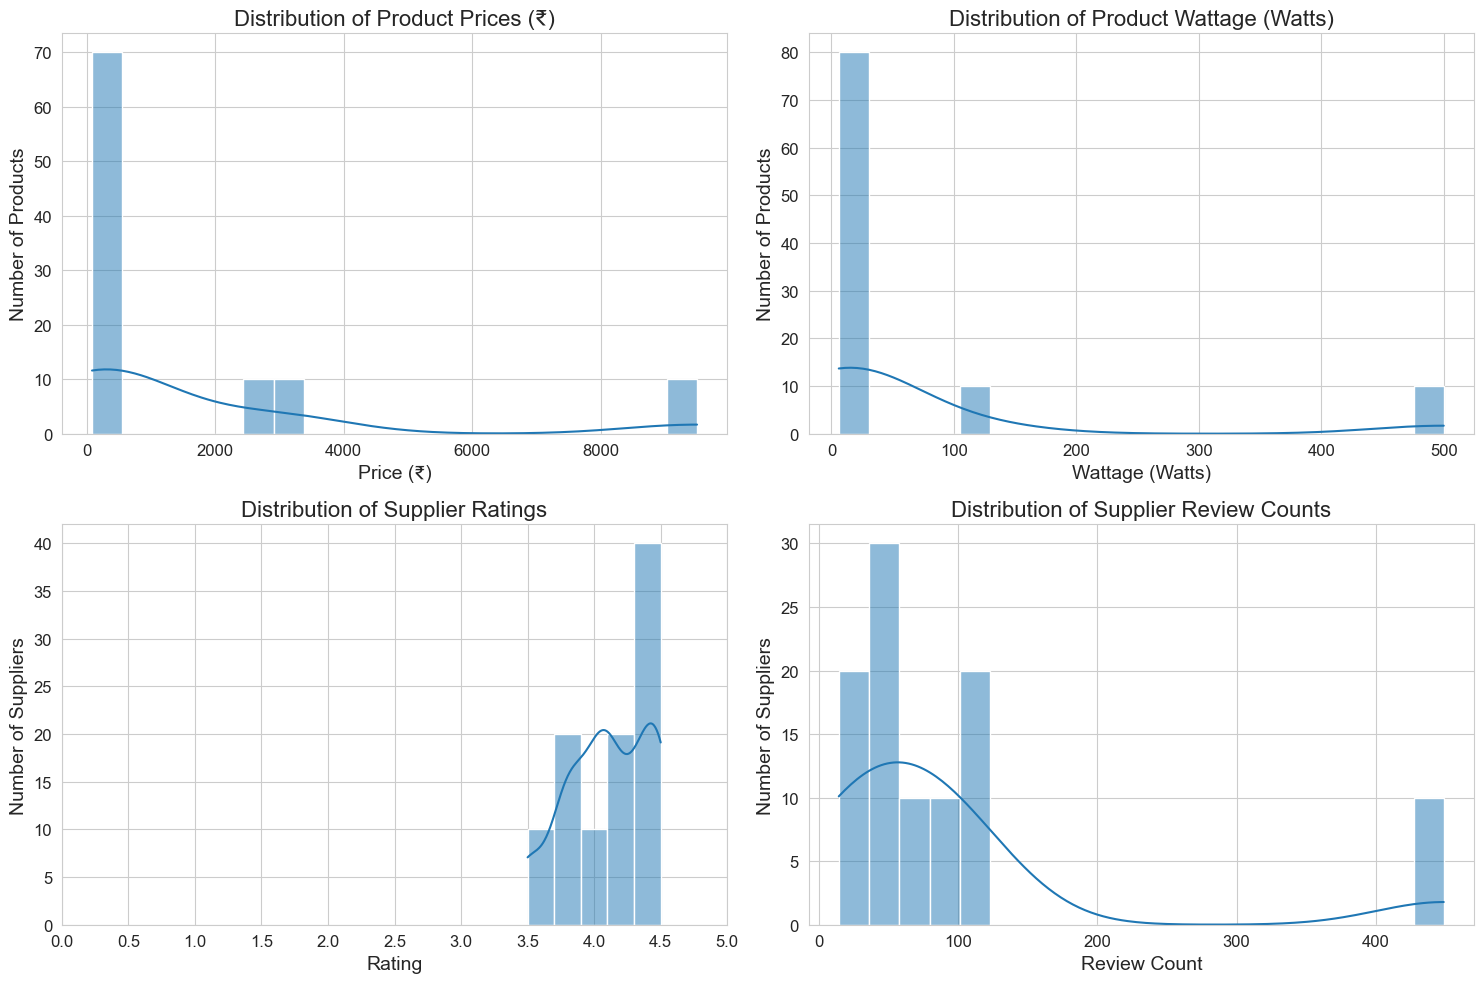


Insights from Summary Statistics and Distributions:
- Price and Wattage distributions: Observe skewness, common ranges, potential outliers.
- Supplier Ratings: Check if ratings are clustered (e.g., mostly high ratings) and their range.
- Supplier Reviews Count: Understand how many reviews suppliers typically have.


In [15]:
# Summary Statistics and Distributions

numerical_cols = [
    'product_price_numeric',
    'pdp_wattage_numeric',
    'pdp_supplier_rating_numeric',
    'pdp_supplier_reviews_count_numeric'
]
display(df[numerical_cols].describe())

# Visualizing Distributions (Histograms)
print("\n--- Visualizing Distributions of Numerical Columns ---")

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(df['product_price_numeric'], kde=True, bins=20)
plt.title('Distribution of Product Prices (₹)')
plt.xlabel('Price (₹)')
plt.ylabel('Number of Products')

plt.subplot(2, 2, 2)
sns.histplot(df['pdp_wattage_numeric'], kde=True, bins=20)
plt.title('Distribution of Product Wattage (Watts)')
plt.xlabel('Wattage (Watts)')
plt.ylabel('Number of Products')

plt.subplot(2, 2, 3)
sns.histplot(df['pdp_supplier_rating_numeric'], kde=True, bins=5)
plt.title('Distribution of Supplier Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Suppliers')
plt.xticks(np.arange(0, 5.5, 0.5)) # Adjust x-ticks for rating

plt.subplot(2, 2, 4)
sns.histplot(df['pdp_supplier_reviews_count_numeric'], kde=True, bins=20)
plt.title('Distribution of Supplier Review Counts')
plt.xlabel('Review Count')
plt.ylabel('Number of Suppliers')

plt.tight_layout()
plt.show()

print("\nInsights from Summary Statistics and Distributions:")
print("- Price and Wattage distributions: Observe skewness, common ranges, potential outliers.")
print("- Supplier Ratings: Check if ratings are clustered (e.g., mostly high ratings) and their range.")
print("- Supplier Reviews Count: Understand how many reviews suppliers typically have.")

#### 2. Identification of Common Attributes
#### Let's explore the most frequent categories in your cleaned categorical columns. This helps understand the common types of LED lights, brands, materials, etc.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pawan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


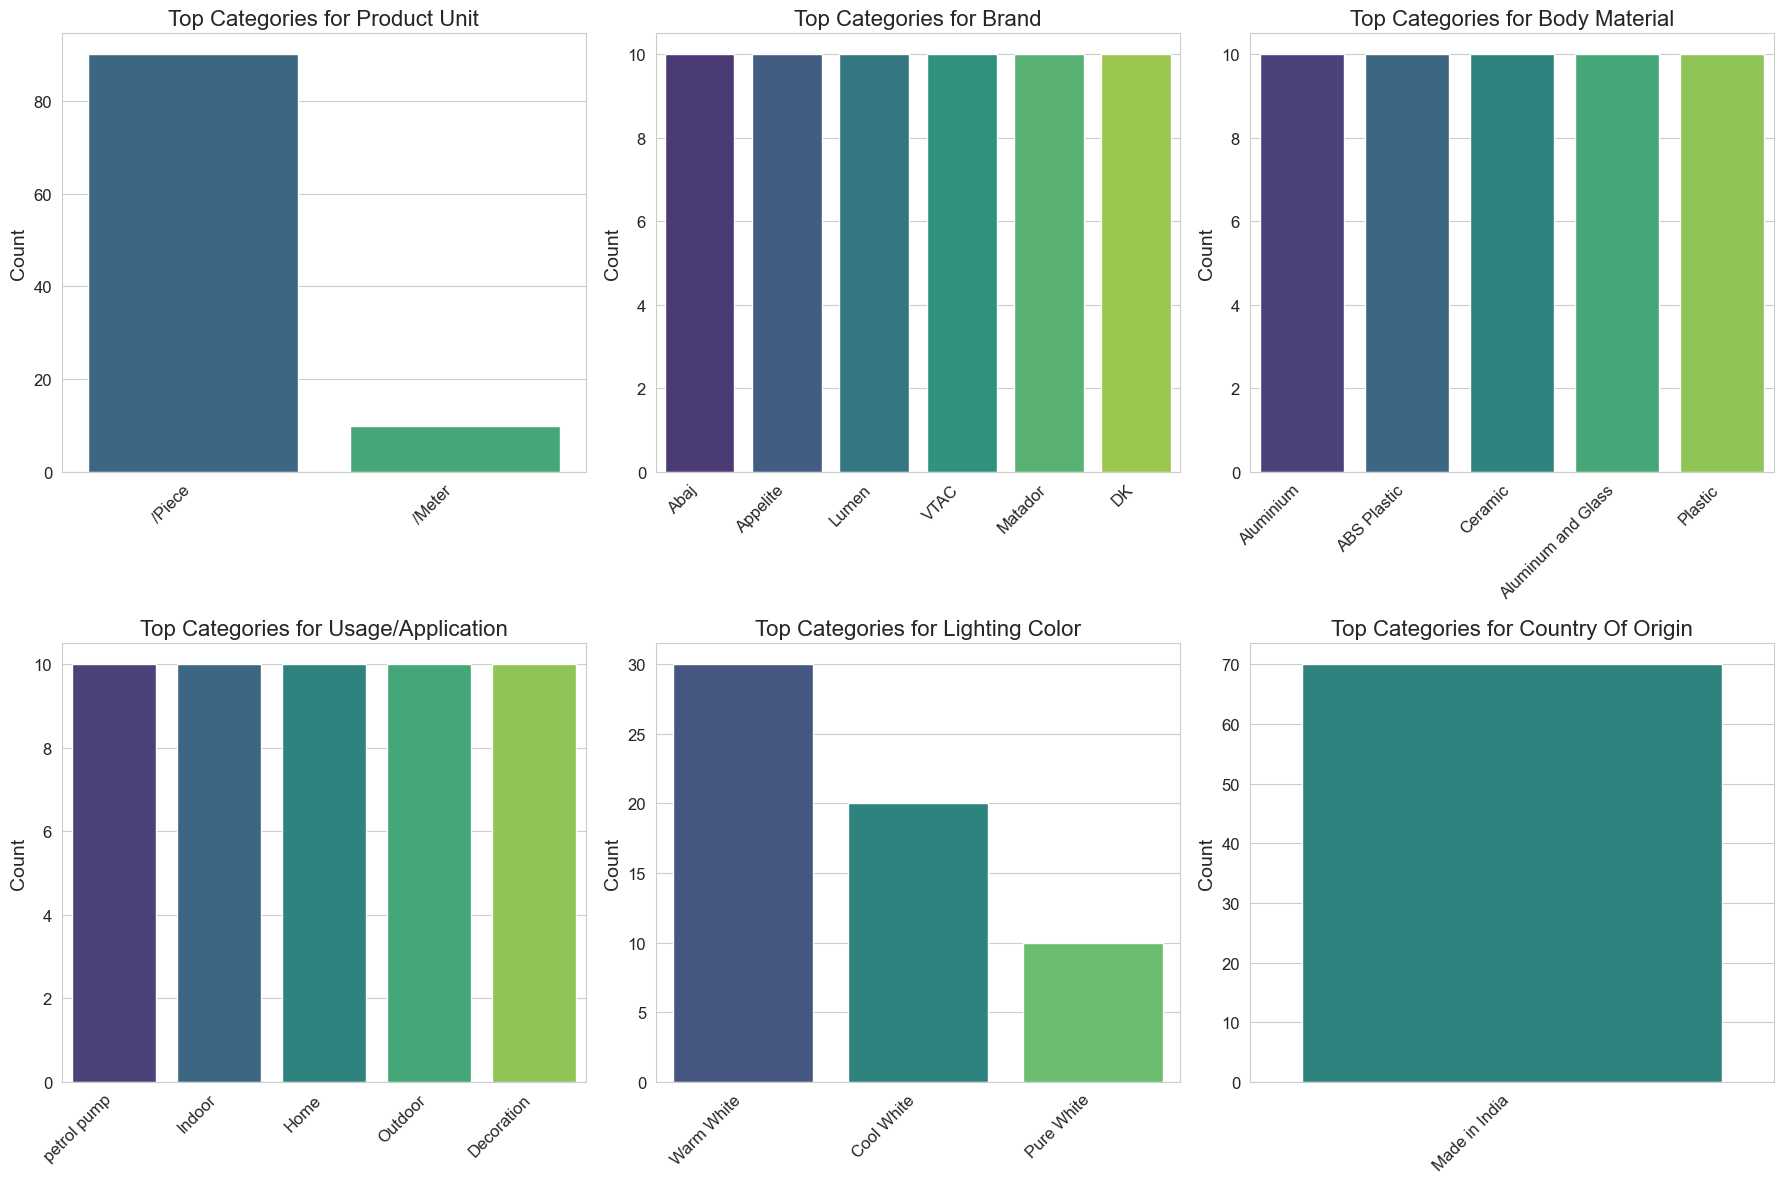


--- Common Keywords in Product Descriptions (Word Cloud) ---
Top 20 most common words in descriptions:
- vtac: 110
- ceiling: 60
- lighting: 50
- range: 40
- available: 40
- wide: 30
- panel: 30
- model: 30
- pixel: 30
- array: 20
- clients: 20
- power: 20
- perfect: 20
- leading: 20
- use: 20
- brand: 20
- happy: 20
- body: 20
- prices: 20
- abaj: 10


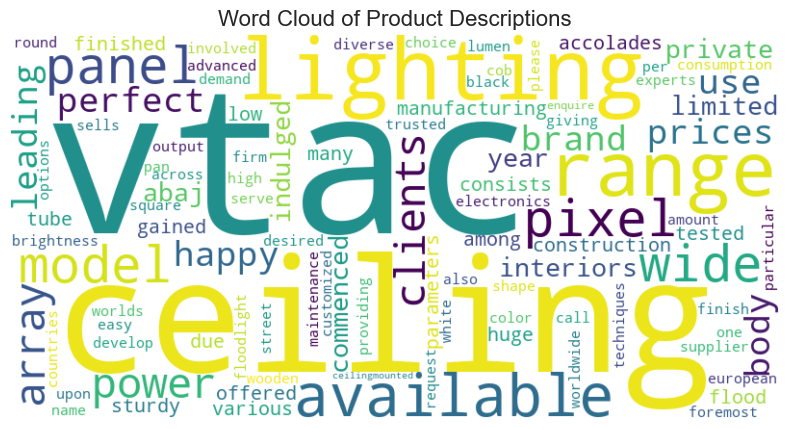


Insights from Common Attributes:
- Product Units: What units are products commonly sold in?
- Top Brands: Identify dominant brands in the dataset.
- Body Material, Usage/Application, Lighting Color, Country of Origin: Discover common specifications.
- Product Descriptions: Highlight key features or terms used by sellers.


In [19]:
# Identification of Common Attributes
import nltk
nltk.download('stopwords')

categorical_cols_for_analysis = [
    'product_unit',
    'pdp_brand',
    'pdp_body_material',
    'pdp_usage/application',
    'pdp_lighting_color',
    'pdp_country_of_origin'
]

plt.figure(figsize=(18, 12))

for i, col in enumerate(categorical_cols_for_analysis):
    plt.subplot(2, 3, i + 1) # Adjust subplot grid based on number of columns
    # Get value counts, excluding 'N/A' if it's not a top category and sort descending
    top_categories = df[col].value_counts().drop('N/A', errors='ignore').head(7) # Exclude 'N/A' for top insights
    sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')
    plt.title(f'Top Categories for {col.replace("pdp_", "").replace("_", " ").title()}')
    plt.xlabel('') # Clear x-label as title is descriptive
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


# Analyze 'pdp_description' for common keywords using a Word Cloud
print("\n--- Common Keywords in Product Descriptions (Word Cloud) ---")

# Combine all descriptions into a single string
# Filter out 'N/A' descriptions as they are not informative
all_descriptions = ' '.join(df[df['pdp_description'] != 'N/A']['pdp_description']).lower()

# Basic text cleaning for word cloud (remove punctuation, numbers)
all_descriptions = re.sub(r'[^a-z\s]', '', all_descriptions)

# Remove common stopwords (you might want to add more domain-specific stopwords)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
# Add some common words that might not be informative like 'led', 'light', 'product'
custom_stopwords = ['led', 'light', 'lights', 'product', 'products', 'india', 'new', 'used', 'etc', 'n/a']
stop_words.update(custom_stopwords)

words = [word for word in all_descriptions.split() if word not in stop_words and len(word) > 2] # Min word length 2

# Generate word frequencies
word_counts = Counter(words)
# Get top 20 most common words for a quick check
print("Top 20 most common words in descriptions:")
for word, count in word_counts.most_common(20):
    print(f"- {word}: {count}")

# Generate Word Cloud
if word_counts:
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=100, contour_width=3, contour_color='steelblue').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Product Descriptions')
    plt.show()
else:
    print("No valid descriptions to generate a word cloud.")

print("\nInsights from Common Attributes:")
print("- Product Units: What units are products commonly sold in?")
print("- Top Brands: Identify dominant brands in the dataset.")
print("- Body Material, Usage/Application, Lighting Color, Country of Origin: Discover common specifications.")
print("- Product Descriptions: Highlight key features or terms used by sellers.")

#### 3. Regional Insights
#### Let's explore the distribution of suppliers across different locations in India.


--- 3. Regional Insights (Supplier Locations) ---
Top 10 Supplier Locations:


supplier_location
Mumbai        30
Ahmedabad     20
Bhopal        10
Gurugram      10
New Delhi     10
Coimbatore    10
Noida         10
Name: count, dtype: int64

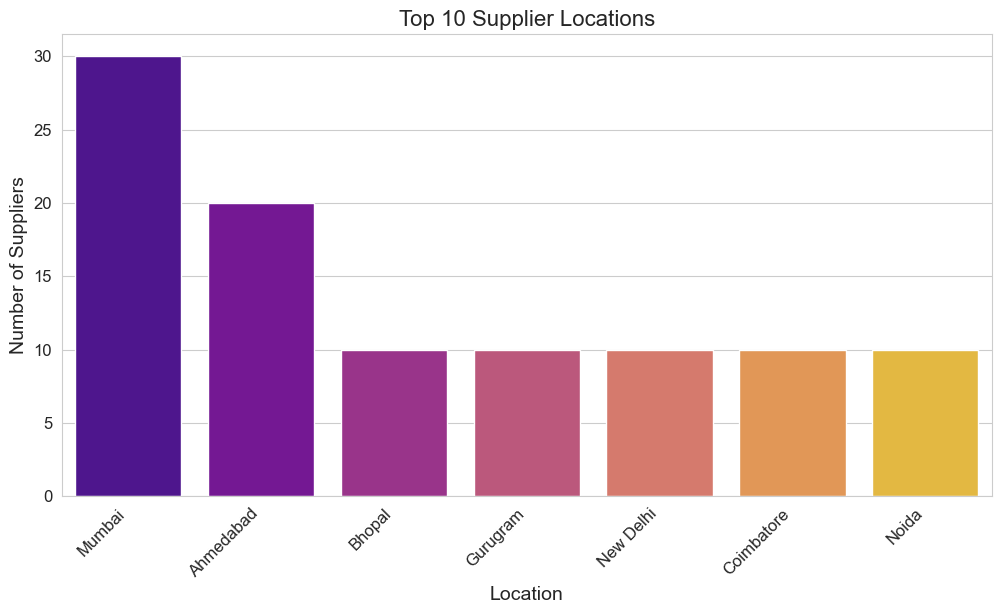


Insights from Regional Analysis:
- Which cities or regions have the highest concentration of LED light suppliers?
- This can indicate manufacturing hubs or major distribution centers.


In [20]:
# Regional Insights

print("\n--- 3. Regional Insights (Supplier Locations) ---")

# Top supplier locations
top_locations = df['supplier_location'].value_counts().head(10) # Adjust as needed
print("Top 10 Supplier Locations:")
display(top_locations)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_locations.index, y=top_locations.values, palette='plasma')
plt.title('Top 10 Supplier Locations')
plt.xlabel('Location')
plt.ylabel('Number of Suppliers')
plt.xticks(rotation=45, ha='right')
plt.show()

print("\nInsights from Regional Analysis:")
print("- Which cities or regions have the highest concentration of LED light suppliers?")
print("- This can indicate manufacturing hubs or major distribution centers.")

#### 4. Relationships and Correlations
#### Now, let's look at how different attributes might be related.

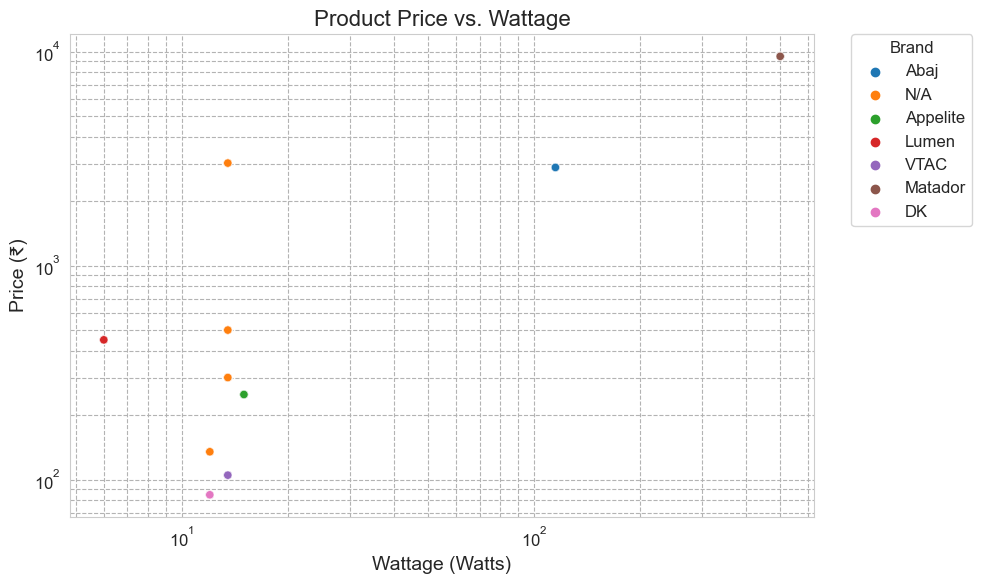

- Price vs. Wattage: Is there a positive correlation? Do higher wattage lights cost more? Are there specific brands that deviate?


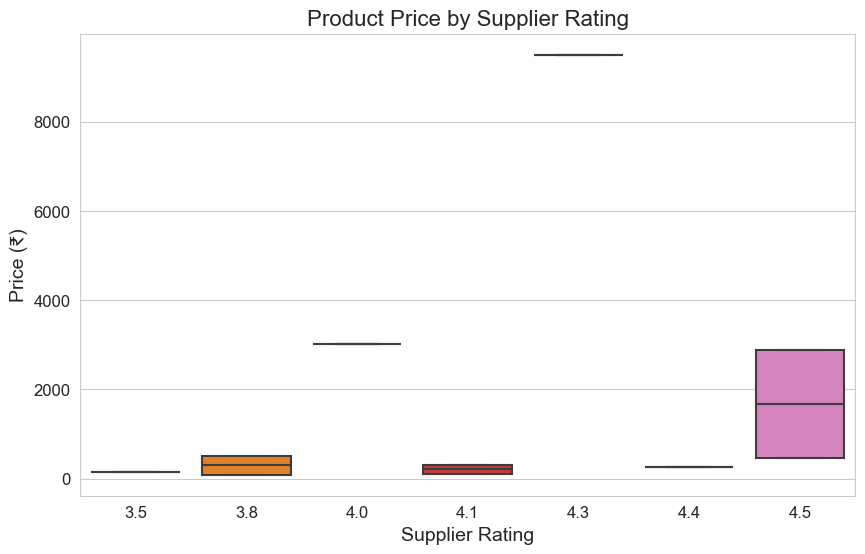

- Price vs. Supplier Rating: Do higher-rated suppliers tend to sell more expensive or cheaper products?

--- Average Price by Top Brands ---
Average Price by Top Brands:


pdp_brand
Matador     9500.0
Abaj        2876.0
Lumen        450.0
Appelite     250.0
VTAC         105.0
Name: product_price_numeric, dtype: float64

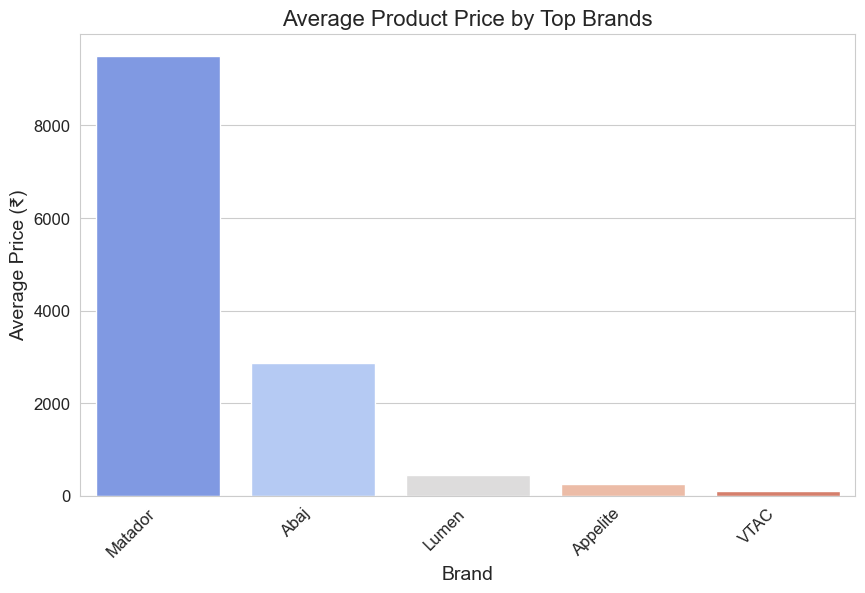

- Average Price by Brand: Are certain brands generally more expensive or affordable?

Insights from Relationships and Correlations:
- Analyze the patterns in scatter plots and box plots to identify potential correlations or group behaviors.
- Understand how numerical features interact and how categorical features influence numerical ones.


In [21]:
# Relationships and Correlations
# Price vs. Wattage
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pdp_wattage_numeric', y='product_price_numeric', data=df, hue='pdp_brand', alpha=0.7)
plt.title('Product Price vs. Wattage')
plt.xlabel('Wattage (Watts)')
plt.ylabel('Price (₹)')
plt.xscale('log') # Log scale helps if wattage has a wide range
plt.yscale('log') # Log scale helps if price has a wide range
plt.grid(True, which="both", ls="--", c=".7")
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

print("- Price vs. Wattage: Is there a positive correlation? Do higher wattage lights cost more? Are there specific brands that deviate?")

# Price vs. Supplier Rating
plt.figure(figsize=(10, 6))
sns.boxplot(x='pdp_supplier_rating_numeric', y='product_price_numeric', data=df)
plt.title('Product Price by Supplier Rating')
plt.xlabel('Supplier Rating')
plt.ylabel('Price (₹)')
plt.show()
print("- Price vs. Supplier Rating: Do higher-rated suppliers tend to sell more expensive or cheaper products?")

# Average Price by Top Brands
print("\n--- Average Price by Top Brands ---")
# Get top 5 brands (excluding 'N/A')
top_brands_list = df['pdp_brand'].value_counts().drop('N/A', errors='ignore').head(5).index.tolist()

if top_brands_list:
    df_top_brands = df[df['pdp_brand'].isin(top_brands_list)]
    avg_price_by_brand = df_top_brands.groupby('pdp_brand')['product_price_numeric'].mean().sort_values(ascending=False)
    print("Average Price by Top Brands:")
    display(avg_price_by_brand)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_price_by_brand.index, y=avg_price_by_brand.values, palette='coolwarm')
    plt.title('Average Product Price by Top Brands')
    plt.xlabel('Brand')
    plt.ylabel('Average Price (₹)')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    print("- Average Price by Brand: Are certain brands generally more expensive or affordable?")
else:
    print("No top brands found for analysis after excluding 'N/A'.")

print("\nInsights from Relationships and Correlations:")
print("- Analyze the patterns in scatter plots and box plots to identify potential correlations or group behaviors.")
print("- Understand how numerical features interact and how categorical features influence numerical ones.")

#### 5. Overall Insights and Hypotheses
#### This is where you summarize your findings and suggest potential next steps or questions for deeper analysis.

In [23]:
# Overall Insights and Hypotheses

print("\n**Key Insights from EDA:**")
print("1.  **Product Price:** (Summarize distribution, common ranges, any outliers).")
print("2.  **Product Wattage:** (Summarize distribution, typical wattage levels, impact of imputation).")
print("3.  **Supplier Performance:** (Summarize rating distribution, review count distribution, general quality).")
print("4.  **Dominant Categories:** (List top brands, common materials, usage types, etc.).")
print("5.  **Geographical Presence:** (Identify key supplier locations).")
print("6.  **Relationships:** (Describe observed correlations, e.g., price-wattage, brand-price).")

print("\n**Potential Hypotheses for Further Analysis:**")
print("1.  **Price-Performance Correlation:** Higher wattage LED lights are generally more expensive, but there might be a point of diminishing returns or premium pricing for specific wattage bands.")
print("2.  **Brand Influence:** Renowned brands command higher prices regardless of wattage, or specific brands offer better price-per-wattage value.")
print("3.  **Supplier Rating Impact:** Higher-rated suppliers might offer products at a premium or be associated with specific product types.")
print("4.  **Regional Specialization:** Certain regions might specialize in specific types of LED lights (e.g., street lights vs. decorative lights) or offer more competitive pricing.")
print("5.  **Market Segmentation:** Products with detailed specifications (non-'N/A' values for brand, material, etc.) might target a different market segment than those with minimal details, potentially influencing pricing or supplier characteristics.")
print("6.  **Demand Indicators:** High review counts or supplier ratings could correlate with higher product demand or trustworthiness.")

print("\n--- EDA Complete. Ready for Deeper Analysis or Modeling. ---")


**Key Insights from EDA:**
1.  **Product Price:** (Summarize distribution, common ranges, any outliers).
2.  **Product Wattage:** (Summarize distribution, typical wattage levels, impact of imputation).
3.  **Supplier Performance:** (Summarize rating distribution, review count distribution, general quality).
4.  **Dominant Categories:** (List top brands, common materials, usage types, etc.).
5.  **Geographical Presence:** (Identify key supplier locations).
6.  **Relationships:** (Describe observed correlations, e.g., price-wattage, brand-price).

**Potential Hypotheses for Further Analysis:**
1.  **Price-Performance Correlation:** Higher wattage LED lights are generally more expensive, but there might be a point of diminishing returns or premium pricing for specific wattage bands.
2.  **Brand Influence:** Renowned brands command higher prices regardless of wattage, or specific brands offer better price-per-wattage value.
3.  **Supplier Rating Impact:** Higher-rated suppliers might offe